## SS7 Comfon Report

In [1]:
#!/usr/bin/env python

from pygraylog.graylogapi import GraylogAPI
import sys
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

version = '0.0.0'

In [2]:
#Variables

log_level = 0
rep_interval = 24 #hours
days_back = 7 #days
period = 8 #number of intervals

In [3]:
#Functions

graylog_con={
        "user":"merger",
        "password":"pc@pM8rger",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":0,
        "limit":1
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)
        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)
        return outputResult

In [4]:
#Prepare a report

start_time = (dt.datetime.now()-dt.timedelta(days=days_back))
start_time=start_time.strftime("%m/%d/%Y 00:00:00")
date_range=pd.date_range(start=start_time,periods=period,freq=str(rep_interval) + 'H')

query_out_ss7='protocol:ss7 AND (m3ua_DPC:1961 OR m3ua_DPC:1962)'
query_in_ss7='protocol:ss7 AND (m3ua_OPC:1961 OR m3ua_OPC:1962)'

res_ss7=np.array([[0,1,2]])

for d in date_range:
    dateFrom = dt.datetime.strptime(d.strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')
    dateTo = dt.datetime.strptime((d+dt.timedelta(hours=rep_interval)).strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')


    gres=api.search.universal.absolute.get(query=query_out_ss7, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
    jsonResult = json.loads(gres)
    msu_out=jsonResult["total_results"]
    
    gres=api.search.universal.absolute.get(query=query_in_ss7, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
    jsonResult = json.loads(gres)
    msu_in=jsonResult["total_results"]
    
    temp=np.array([[dateTo,msu_out,msu_in]])
    res_ss7=np.concatenate([res_ss7,temp],axis=0)
    
df_ss7=DataFrame(res_ss7[1:],columns=['Rep_end_time','MSU_out','MSU_in'])
df_ss7['Total']=df_ss7['MSU_out']+ df_ss7['MSU_in']
df_ss7

,Rep_end_time,MSU_out,MSU_in,Total
0,2018-05-05 00:00:00,3511123,3575724,7086847
1,2018-05-06 00:00:00,3284471,3363307,6647778
2,2018-05-07 00:00:00,3316680,3391026,6707706
3,2018-05-08 00:00:00,3362961,3428827,6791788
4,2018-05-09 00:00:00,3427637,3495233,6922870
5,2018-05-10 00:00:00,3428676,3493163,6921839
6,2018-05-11 00:00:00,3482853,3551383,7034236
7,2018-05-12 00:00:00,870930,889028,1759958


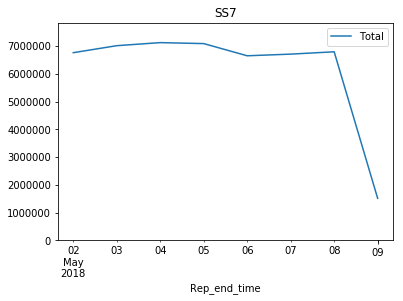

In [14]:
#Visualisation

df_ss7.plot(x='Rep_end_time',y=['Total'],ylim=[0,max(df_ss7['Total'])*1.1])
plt.title('SS7')
plt.show()

### Download the report into SQLite DB

In [8]:
import sqlite3
conn = sqlite3.connect('./DATA/test.sqlite') #"The connect operation makes a “connection” to the database stored in the file test.sqlite3 in the current directory."
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS REP_SS7_MSU')
cur.execute('CREATE TABLE REP_SS7_MSU (REP_END_TIME TEXT, MSU_OUT INTEGER, MSU_IN INTEGER)')

df_ss71=df_ss7[['Rep_end_time','MSU_out','MSU_in']].copy()

df_ss71.to_sql(name='REP_SS7_MSU', con=conn, if_exists = 'append', index=False)
conn.commit()
cur.execute('SELECT * FROM REP_SS7_MSU')
for row in cur:
    print(row)
conn.close()

(u'2018-05-05 00:00:00', 3511123, 3575724)
(u'2018-05-06 00:00:00', 3284471, 3363307)
(u'2018-05-07 00:00:00', 3316680, 3391026)
(u'2018-05-08 00:00:00', 3362961, 3428827)
(u'2018-05-09 00:00:00', 3427637, 3495233)
(u'2018-05-10 00:00:00', 3428676, 3493163)
(u'2018-05-11 00:00:00', 3482853, 3551383)
(u'2018-05-12 00:00:00', 870930, 889028)


## Load SS7 report Script
Working version

version = '0.0.1' with OPC/DPC

In [20]:
#!/usr/bin/env python

from pygraylog.graylogapi import GraylogAPI
import sys
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime as dt
import sqlite3

version = '0.0.1'

#Variables

log_level = 0
rep_interval = 24 #hours
days_back = 1 #days
period = 1 #number of intervals
db_path = './DATA/test.sqlite'

#Functions

graylog_con={
        "user":"merger",
        "password":"pc@pM8rger",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":0,
        "limit":1
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)
        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)
        return outputResult

#Prepare a report

start_time = (dt.datetime.now()-dt.timedelta(days=days_back))
start_time = start_time.strftime("%m/%d/%Y 00:00:00")
date_range = pd.date_range(start=start_time,periods=period,freq=str(rep_interval) + 'H')

#query_out_ss7='protocol:ss7 AND (m3ua_DPC:1961 OR m3ua_DPC:1962)'
#query_in_ss7='protocol:ss7 AND (m3ua_OPC:1961 OR m3ua_OPC:1962)'

res_ss7=np.array([[0,1,2,3]])

for d in date_range:
    dateFrom = dt.datetime.strptime(d.strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')
    dateTo = dt.datetime.strptime((d+dt.timedelta(hours=rep_interval)).strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')

    for rb in [2505,2506]:
        for cf in [1961,1962]:
            query='protocol:ss7 AND m3ua_OPC:{} AND m3ua_DPC:{}'.format(rb,cf)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res=jsonResult["total_results"]
            temp=np.array([[dateTo,rb,cf,query_res]])
            res_ss7=np.concatenate([res_ss7,temp],axis=0)
            
            query='protocol:ss7 AND m3ua_OPC:{} AND m3ua_DPC:{}'.format(cf,rb)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res=jsonResult["total_results"]
            temp=np.array([[dateTo,cf,rb,query_res]])
            res_ss7=np.concatenate([res_ss7,temp],axis=0)
    
df_ss7=DataFrame(res_ss7[1:],columns=['Rep_end_time','OPC','DPC','MSU'])

conn = sqlite3.connect(db_path)

#---
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS REP_SS7_MSU ')
cur.execute('CREATE TABLE REP_SS7_MSU (REP_END_TIME TEXT, OPC INTEGER, DPC INTEGER, MSU INTEGER)')
#---

df_ss7.to_sql(name='REP_SS7_MSU', con=conn, if_exists = 'append', index=False)
conn.commit()
conn.close()

In [18]:
#To check the data

conn = sqlite3.connect(db_path)
cur = conn.cursor()
cur.execute('SELECT * FROM REP_SS7_MSU')
for row in cur:
    print(row)
conn.close()

(u'2018-05-12 00:00:00', 2505, 1961, 862850)
(u'2018-05-12 00:00:00', 1961, 2505, 834859)
(u'2018-05-12 00:00:00', 2505, 1962, 986560)
(u'2018-05-12 00:00:00', 1962, 2505, 954114)
(u'2018-05-12 00:00:00', 2506, 1961, 904570)
(u'2018-05-12 00:00:00', 1961, 2506, 970726)
(u'2018-05-12 00:00:00', 2506, 1962, 804441)
(u'2018-05-12 00:00:00', 1962, 2506, 875770)


In [12]:
!python ss7_sqllite_db_py2.py

## Diameter Comfon Report Script
Working version

In [32]:
#!/usr/bin/env python

from pygraylog.graylogapi import GraylogAPI
import sys
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime as dt
import sqlite3

version = '0.0.1'

#Variables

log_level = 0
rep_interval = 24 #hours
days_back = 1 #days
period = 1 #number of intervals
db_path = './DATA/test.sqlite'

#Functions

graylog_con={
        "user":"merger",
        "password":"pc@pM8rger",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":0,
        "limit":1
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)
        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)
        return outputResult
    
#Prepare a report

start_time = (dt.datetime.now()-dt.timedelta(days=days_back))
start_time=start_time.strftime("%m/%d/%Y 00:00:00")
date_range=pd.date_range(start=start_time,periods=period,freq=str(rep_interval) + 'H')

res_diam=np.array([[0,1,2,3]])

for d in date_range:
    dateFrom = dt.datetime.strptime(d.strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')
    dateTo = dt.datetime.strptime((d+dt.timedelta(hours=rep_interval)).strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')

    for rb in ['176.10.116.194','5.148.189.250']:
        for cf in ['195.211.12.98','91.221.82.98']:
            query='protocol:diameter AND ip_src:{} AND ip_dst:{}'.format(rb,cf)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res=jsonResult["total_results"]
            temp=np.array([[dateTo,rb,cf,query_res]])
            res_diam=np.concatenate([res_diam,temp],axis=0)
            
            query='protocol:diameter AND ip_src:{} AND ip_dst:{}'.format(cf,rb)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res=jsonResult["total_results"]
            temp=np.array([[dateTo,cf,rb,query_res]])
            res_diam=np.concatenate([res_diam,temp],axis=0)

res_diam=DataFrame(res_diam[1:],columns=['Rep_end_time','IP_SRC','IP_DST','MSG'])

conn = sqlite3.connect(db_path)

#---For the fist time to create the table
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS REP_DIAM_MSG ')
cur.execute('CREATE TABLE REP_DIAM_MSG (REP_END_TIME TEXT, IP_SRC TEXT, IP_DST TEXT, MSG INTEGER)')
#---

res_diam.to_sql(name='REP_DIAM_MSG', con=conn, if_exists = 'append', index=False)
conn.commit()
conn.close()

In [31]:
#To check the data

db_path = './DATA/test.sqlite'

conn = sqlite3.connect(db_path)
cur = conn.cursor()
cur.execute('SELECT * FROM REP_DIAM_MSG')
for row in cur:
    print(row)
conn.close()

(u'2018-05-16 00:00:00', u'176.10.116.194', u'195.211.12.98', 175909)
(u'2018-05-16 00:00:00', u'195.211.12.98', u'176.10.116.194', 175968)
(u'2018-05-16 00:00:00', u'176.10.116.194', u'91.221.82.98', 233509)
(u'2018-05-16 00:00:00', u'91.221.82.98', u'176.10.116.194', 233855)
(u'2018-05-16 00:00:00', u'5.148.189.250', u'195.211.12.98', 157202)
(u'2018-05-16 00:00:00', u'195.211.12.98', u'5.148.189.250', 157444)
(u'2018-05-16 00:00:00', u'5.148.189.250', u'91.221.82.98', 259179)
(u'2018-05-16 00:00:00', u'91.221.82.98', u'5.148.189.250', 258610)


### Developments

In [38]:
# Create a dictionary for PC

import sqlite3

l_name_list = ['RB']

db_path = './DATA/test.sqlite'
#db_path = '/opt/sqlite/nsstat.sqlite'
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS DICT_SS7_PC')
cur.execute('''
CREATE TABLE DICT_SS7_PC (DEST_NAME TEXT,PC_NAME TEXT,PC INTEGER)
''')
cur.execute('''
INSERT INTO DICT_SS7_PC (DEST_NAME,PC_NAME, PC)
VALUES
('OWN','RB_STP1',2505),
('OWN','RB_STP2',2506),
('OWN','RB_STP2',700),
('OWN','RB_STP',200),
('OWN','RB_STP1',1093),
('OWN','RB_STP2',1094),
('OWN','RB_STP1',2000),
('OWN','RB_STP2',2001),
('OWN','RB_STP1',40),
('OWN','RB_STP',800),
('COMFONE','COMFONE_STP1',1961),
('COMFONE','COMFONE_STP2',1962),
('LAB','LAB_STP',40),
('DMI','DMI_STP',199),
('C9','C9_STP',16281),
('MAXCOM','MAXCOM_STP',6009),
('CITICTEL','CITICTEL_STP',200),
('NAKA','NAKA_STP1',781),
('NAKA','NAKA_STP2',782),
('TELZAR','TELZAR_STP1',7138)
''')

sql_str = "SELECT DISTINCT PC FROM DICT_SS7_PC WHERE DEST_NAME != 'OWN'"
print(sql_str)
cur.execute(sql_str)
result = cur.fetchall()
dest_pc = [i[0] for i in result]
print dest_pc


sql_str = "SELECT PC FROM DICT_SS7_PC WHERE DEST_NAME='OWN'"
print(sql_str)
cur.execute(sql_str)
result = cur.fetchall()
own_pc = [i[0] for i in result]
print own_pc
    
conn.commit()
conn.close()

SELECT DISTINCT PC FROM DICT_SS7_PC WHERE DEST_NAME != 'OWN'
[1961, 1962, 40, 199, 16281, 6009, 200, 781, 782, 7138]
SELECT PC FROM DICT_SS7_PC WHERE DEST_NAME='OWN'
[2505, 2506, 700, 200, 1093, 1094, 2000, 2001, 40, 800]


In [39]:
#!/usr/bin/env python

from pygraylog.graylogapi import GraylogAPI
import sys
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime as dt
import sqlite3

version = '0.0.2'

#Variables

log_level = 0
rep_interval = 24 #hours
days_back = 1 #days
period = 1 #number of intervals
db_path = './DATA/test.sqlite'

#Functions

graylog_con={
        "user":"merger",
        "password":"pc@pM8rger",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":0,
        "limit":1
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)
        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)
        return outputResult

#Prepare a report

start_time = (dt.datetime.now()-dt.timedelta(days=days_back))
start_time = start_time.strftime("%m/%d/%Y 00:00:00")
date_range = pd.date_range(start=start_time,periods=period,freq=str(rep_interval) + 'H')

res_ss7=np.array([[0,1,2,3]])

conn = sqlite3.connect(db_path)
cur = conn.cursor()

sql_str = "SELECT DISTINCT PC FROM DICT_SS7_PC WHERE DEST_NAME != 'OWN'"
cur.execute(sql_str)
result = cur.fetchall()
dest_pc = [i[0] for i in result]

sql_str = "SELECT PC FROM DICT_SS7_PC WHERE DEST_NAME='OWN'"
cur.execute(sql_str)
result = cur.fetchall()
own_pc = [i[0] for i in result]

for d in date_range:
    dateFrom = dt.datetime.strptime(d.strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')
    dateTo = dt.datetime.strptime((d+dt.timedelta(hours=rep_interval)).strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')

    for rb in own_pc:
        for cf in dest_pc:
            query='protocol:ss7 AND m3ua_OPC:{} AND m3ua_DPC:{}'.format(rb,cf)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res_1=jsonResult["total_results"]
                        
            query='protocol:ss7 AND m3ua_OPC:{} AND m3ua_DPC:{}'.format(cf,rb)
            gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
            jsonResult = json.loads(gres)
            query_res_2=jsonResult["total_results"]
            
            if (query_res_1 + query_res_2) > 0:
                temp=np.array([[dateTo,rb,cf,query_res_1]])
                res_ss7=np.concatenate([res_ss7,temp],axis=0)
                temp=np.array([[dateTo,cf,rb,query_res_2]])
                res_ss7=np.concatenate([res_ss7,temp],axis=0)
    
df_ss7=DataFrame(res_ss7[1:],columns=['Rep_end_time','OPC','DPC','MSU'])

#---
cur.execute('DROP TABLE IF EXISTS REP_SS7_MSU ')
cur.execute('CREATE TABLE REP_SS7_MSU (REP_END_TIME TEXT, OPC INTEGER, DPC INTEGER, MSU INTEGER)')
#---

df_ss7.to_sql(name='REP_SS7_MSU', con=conn, if_exists = 'append', index=False)
conn.commit()
conn.close()